# [機械学習] ロジスティック回帰(およびソフトマックス回帰)でMNISTの分類

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
import matplotlib.pyplot as plt

import numpy as np

np.random.seed(34)

In [47]:
# logの中身が0になるのを防ぐ
def np_log(x):
    return np.log(np.clip(a=x, a_min=1e-10, a_max=1e+10))

In [48]:
def softmax(x, axis=1):
    x -= x.max(axis, keepdims=True)   # expのoverflowを防ぐ
    x_exp = np.exp(x)
    return x_exp / x_exp.sum(axis, keepdims=True)

In [49]:
(x_mnist_1, y_mnist_1), (x_mnist_2, y_mnist_2) = mnist.load_data()

x_mnist = np.r_[x_mnist_1, x_mnist_2]
y_mnist = np.r_[y_mnist_1, y_mnist_2]
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = mnist.load_data()

x_mnist = x_train_raw
y_mnist = y_train_raw
x_test_mnist = x_test_raw.astype('float32') / 255.
x_test_mnist = x_test_mnist.reshape(x_test_mnist.shape[0], -1)
y_test_mnist = np.eye(10)[y_test_raw]

In [50]:
x_mnist = x_mnist.astype('float32') / 255.  # 画素値のスケーリング: 0 - 255 (整数) → 0.0 - 1.0 (浮動小数点数)
y_mnist = np.eye(N=10)[y_mnist.astype('int32').flatten()]  # 整数ラベル (0–9) を one-hot ベクトル に変換

x_mnist=x_mnist.reshape(x_mnist.shape[0],-1)  # 画素の平坦化: 28 * 28 (2次元画像) → 784 (1次元画像)

x_train_mnist, x_valid_mnist, y_train_mnist, y_valid_mnist = train_test_split(x_mnist, y_mnist, test_size=10000)

In [51]:
W_mnist = np.random.uniform(low=-0.08, high=0.08, size=(784, 10)).astype('float32')  # 重み: (784, 10)
b_mnist = np.zeros(shape=(10,)).astype('float32')

In [52]:
def train_mnist(x, y, eps=0.1):

    global W_mnist, b_mnist

    batch_size = x.shape[0]

    # 予測
    y_hat = softmax(np.matmul(x, W_mnist) + b_mnist)  # (batch_size, 出力の次元数)

    # 目的関数の評価
    cost = (- y * np_log(y_hat)).sum(axis=1).mean()
    delta = y_hat - y  # (batch_size, 出力の次元数)

    # パラメータの更新
    lambda_ = 1e-4
    dW = np.matmul(x.T, delta) / batch_size + lambda_ * W_mnist
    db = delta.mean(axis=0)  # バイアス勾配
    W_mnist -= eps * dW
    b_mnist -= eps * db

    return cost

def valid_mnist(x, y):
    y_hat = softmax(np.matmul(x, W_mnist) + b_mnist)
    cost = (- y * np_log(y_hat)).sum(axis=1).mean()

    return cost, y_hat

In [53]:
for epoch in range(200):
    perm = np.random.permutation(len(x_train_mnist))
    x_train_mnist = x_train_mnist[perm]
    y_train_mnist = y_train_mnist[perm]

    for i in range(0, len(x_train_mnist), batch_size):
        x_batch = x_train_mnist[i:i+batch_size]
        y_batch = y_train_mnist[i:i+batch_size]
        cost = train_mnist(x_batch, y_batch, eps=0.1)

    if epoch % 10 == 9 or epoch == 0:
        cost_v, y_pred = valid_mnist(x_valid_mnist, y_valid_mnist)
        acc = accuracy_score(
            y_valid_mnist.argmax(axis=1),
            y_pred.argmax(axis=1)
        )
        print(
            f"EPOCH {epoch+1}: "
            f"Valid Loss={cost_v:.3f}, Valid Acc={acc:.3f}"
        )

EPOCH 1: Valid Loss=0.410, Valid Acc=0.890
EPOCH 10: Valid Loss=0.297, Valid Acc=0.917
EPOCH 20: Valid Loss=0.285, Valid Acc=0.922
EPOCH 30: Valid Loss=0.282, Valid Acc=0.924
EPOCH 40: Valid Loss=0.279, Valid Acc=0.924
EPOCH 50: Valid Loss=0.277, Valid Acc=0.925
EPOCH 60: Valid Loss=0.277, Valid Acc=0.924
EPOCH 70: Valid Loss=0.275, Valid Acc=0.926
EPOCH 80: Valid Loss=0.275, Valid Acc=0.926
EPOCH 90: Valid Loss=0.274, Valid Acc=0.926
EPOCH 100: Valid Loss=0.274, Valid Acc=0.926
EPOCH 110: Valid Loss=0.275, Valid Acc=0.925
EPOCH 120: Valid Loss=0.274, Valid Acc=0.926
EPOCH 130: Valid Loss=0.274, Valid Acc=0.926
EPOCH 140: Valid Loss=0.274, Valid Acc=0.925
EPOCH 150: Valid Loss=0.274, Valid Acc=0.924
EPOCH 160: Valid Loss=0.274, Valid Acc=0.925
EPOCH 170: Valid Loss=0.275, Valid Acc=0.924
EPOCH 180: Valid Loss=0.274, Valid Acc=0.924
EPOCH 190: Valid Loss=0.274, Valid Acc=0.924
EPOCH 200: Valid Loss=0.273, Valid Acc=0.925


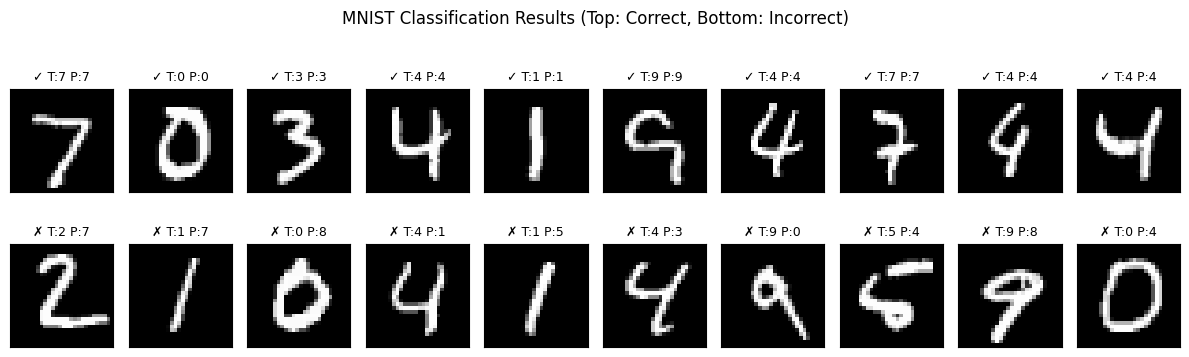

In [45]:
y_test_true = y_test_mnist.argmax(axis=1)
y_test_pred_label = y_test_pred.argmax(axis=1)

def show_correct_incorrect(x, y_true, y_pred, n=10):
    """
    正解・不正解を画像で表示
    """
    correct_idx = np.where(y_true == y_pred)[0]
    incorrect_idx = np.where(y_true != y_pred)[0]

    fig = plt.figure(figsize=(12, 4))

    # 正解例
    for i, idx in enumerate(correct_idx[:n]):
        ax = fig.add_subplot(2, n, i+1, xticks=[], yticks=[])
        ax.imshow(x[idx].reshape(28, 28), cmap="gray")
        ax.set_title(f"✓ T:{y_true[idx]} P:{y_pred[idx]}", fontsize=9)

    # 不正解例
    for i, idx in enumerate(incorrect_idx[:n]):
        ax = fig.add_subplot(2, n, n+i+1, xticks=[], yticks=[])
        ax.imshow(x[idx].reshape(28, 28), cmap="gray")
        ax.set_title(f"✗ T:{y_true[idx]} P:{y_pred[idx]}", fontsize=9)

    plt.suptitle("MNIST Classification Results (Top: Correct, Bottom: Incorrect)")
    plt.tight_layout()
    plt.show()

show_correct_incorrect(
    x_test_mnist,
    y_test_true,
    y_test_pred_label,
    n=10
)
